## Обратная связь


> Хотелось бы больше погружения в код, как что работает в коде

Останавливайте, спрашивайте 🙏🏻

# Recap

### 🧮 Мотивация

Нейронная сеть -- большая формула с коэффициентами (весами).

Нейросети сами выучивают признаки, которые важны для предикта. Не надо заниматься фича-инженирингом.

### 📉 Градиенты

Для вычисления градиентов весов мы используем алгоритм обратного распространения ошибки.

### 📏 Нелинейность

Если из нейросети убрать все нелинейные преобразования, она выродится в линейную регрессию. `ReLU` - неплохой бейзлайн для ф-и активации.

### 🔮 Инициализация

Веса нейросети по умолчанию инициализируются рандомно, но так, чтобы сохранить дисперсию на каждом слое.


-----



# Оптимизация нейросетей. Дропаут.


# План занятия

## Цели
- Понять связь: **лосс → градиенты → оптимизатор → обобщение**.
- Уметь выбирать лосс под задачу и читать его входы/выходы.
- Понимать, что делает оптимизатор (SGD / momentum / Adam) и какие у него затраты по памяти.
- Понимать базовые методы регуляризации: dropout, weight decay (Adam vs AdamW), label smoothing.
- Уметь пользоваться **LR scheduler** и **warmup** и не путать порядок вызовов.
- Логировать метрики в **TensorBoard**.

## Задачи
Оптимизация начинается с лосса. Лосс обычно выбирают в зависимости от задачи.

### Делаем регрессию

**Mean Squared Error** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss))

In [ ]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.randn(3, 2)

output = loss(input, target)
output


### Делаем классификацию:

**Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


In [ ]:
# Example of target with class indices

import torch.nn as nn

loss = nn.CrossEntropyLoss() # nn.Softmax + nn.NLLoss
input = torch.randn(3, 5, requires_grad=True) # [ batch_size, class_probability ]

# [ batch_size ] -- метки каждого класса, каждая метка -- это число от [0 до 5)
target = torch.empty(3, dtype=torch.long).random_(5)

output = loss(input, target)
output

#### ❓ **Вопрос**: зачем делать Softmax? Ведь на выходе модельки мы уже получаем логиты?

### Делаем теггирование:

**Binary Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html))


Примером может быть задача тэгорования треков: один трек может именть несколько жанров: `pop`, `rock`, `jazz`, `russian`, `1980s`...

In [ ]:
sigmoid = nn.Sigmoid()
loss = nn.BCELoss()

input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(sigmoid(input), target)
output

# Оптимизация

### Моделька

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MLP(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        self.inner = nn.Sequential(nn.Linear(2, 16), # заведомо довольно большая модель, чтобы очевиднее был эффект переобучения и дропаута
                                   nn.ReLU(),
                                   nn.Linear(16, 16),
                                   nn.ReLU(),
                                   nn.Linear(16, 1))

    def forward(self, x):
        return self.inner(x)


In [ ]:
# В этом методе градиенты всегда будут рандомными!
# В реальности данные и метки должны браться из датасета, а не из рандома
def example_compute_random_gradients(model):
    batch_size = 3
    model_input = torch.rand([batch_size, 2])
    target_batch_values = torch.randint(0, 1, [batch_size]) * 2 - 1 # -1/1 target values

    model_prediction = model.forward(model_input)

    loss = F.relu(1 - target_batch_values * model_prediction).mean()

    model.zero_grad()
    loss.backward()  # compute loss

### Hands optimizer


In [ ]:
model = MLP()
example_compute_random_gradients(model)

learning_rate = 0.01

# optimization step
for p in model.parameters():
    p.data = p.data - learning_rate * p.grad

### Pytorch Optimizer

In [ ]:
from torch.optim import SGD, Adam

In [ ]:
model = MLP()
sgd_optimizer = SGD(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

sgd_optimizer.step() # итериуется по сохраненным на этапе инициализации параметрам и обновляет параметры

In [ ]:
## Другие оптимизаторы
from torch.optim import Adam

adam_optimizer = Adam(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

adam_optimizer.step()

## Adam: формулы и интуиция

Обозначим градиент на шаге $t$: $g_t = \nabla_\theta \mathcal{L}(\theta_t)$.

**Экспоненциальные скользящие средние (моменты):**
- Первый момент (средний градиент):

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$

- Второй момент (средний квадрат градиента):

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$

**Bias correction** (важно на первых шагах, потому что $m_0=v_0=0$):

$$
\hat m_t = \frac{m_t}{1-\beta_1^t}, \quad \hat v_t = \frac{v_t}{1-\beta_2^t}
$$

**Шаг обновления:**

$$
\theta_{t+1} = \theta_t - \alpha \frac{\hat m_t}{\sqrt{\hat v_t} + \varepsilon}
$$

Интуиция:
- $\hat m_t$ похож на momentum (направление шага)
- $\sqrt{\hat v_t}$ нормирует шаг по координатам (где градиенты «шумнее/больше» — там шаг меньше)
- поэтому Adam часто быстрее «разгоняется» и устойчивее к плохому масштабу признаков/слоев

Можем вспомнить, что оптимизатор хранит статиситики по градиентам параметров (моменты)!

Для хранения моментов тоже используется память на видео-карте.

In [ ]:
adam_optimizer.state_dict()

Кстати! А как работает скользящее среднее?

In [ ]:
import matplotlib.pyplot as plt

timeseries_len = 100

outlier = torch.zeros(timeseries_len)
outlier[55] = 3

           # рандомный шум                   + квадратный корень                       + выброс
raw_data = torch.rand([timeseries_len]) + torch.sqrt(torch.arange(timeseries_len)) + outlier
raw_data = raw_data / 100

beta_values = torch.tensor([ 0.5, 0.9, 0.99 ])

mooving_avarages = torch.zeros([beta_values.shape[0], timeseries_len])
mooving_avarages[:, 0] = raw_data[0]

for i in range(1, timeseries_len):
    mooving_avarages[:, i] = mooving_avarages[:, i-1] * beta_values + (1-beta_values) * raw_data[i]

plt.plot(raw_data, label='raw')
for beta_i, beta in enumerate(beta_values.numpy().tolist()):
    plt.plot(mooving_avarages[beta_i, :], label=f"beta {beta:.2f}")

plt.legend()
plt.title("Mooving average demo")

#### ❓ **Вопрос:** Какую проблему решает скользящее среднее?

## Demo optimizers

In [ ]:
!nvidia-smi

In [ ]:
import torch
import torch.optim as optim

# Используем MLP из этого ноутбука
mlp_adam = MLP()
mlp_sgd = MLP()

mlp_adam

In [22]:
# Сколько памяти съедает состояние оптимизатора?
# (на GPU это тоже хранится, поэтому Adam «дороже» по памяти)

import torch


def optimizer_state_size_bytes(optimizer: torch.optim.Optimizer) -> int:
    total = 0
    for state in optimizer.state.values():
        if not isinstance(state, dict):
            continue
        for v in state.values():
            if torch.is_tensor(v):
                total += v.numel() * v.element_size()
    return total


def model_params_size_bytes(model: torch.nn.Module) -> int:
    return sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)


def init_optimizer_state(optimizer: torch.optim.Optimizer, model: torch.nn.Module) -> None:
    x = torch.randn(2048, 2)
    y = torch.randn(2048, 1)

    optimizer.zero_grad()
    pred = model(x)
    loss = torch.nn.functional.mse_loss(pred, y)
    loss.backward()
    optimizer.step()


model_sgd = MLP()
sgd = torch.optim.SGD(model_sgd.parameters(), lr=1e-2)
init_optimizer_state(sgd, model_sgd)

model_adam = MLP()
adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
init_optimizer_state(adam, model_adam)

print("MLP params:", round(model_params_size_bytes(model_sgd) / 1024, 2), "KB")
print("SGD state:", round(optimizer_state_size_bytes(sgd) / 1024, 2), "KB")
print("Adam state:", round(optimizer_state_size_bytes(adam) / 1024, 2), "KB")

MLP params: 1.32 KB
SGD state: 0.0 KB
Adam state: 2.66 KB


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp_adam = mlp_adam.to(device)
mlp_sgd = mlp_sgd.to(device)

x = torch.rand(4096, 2, device=device)
y = torch.rand(4096, 1, device=device)

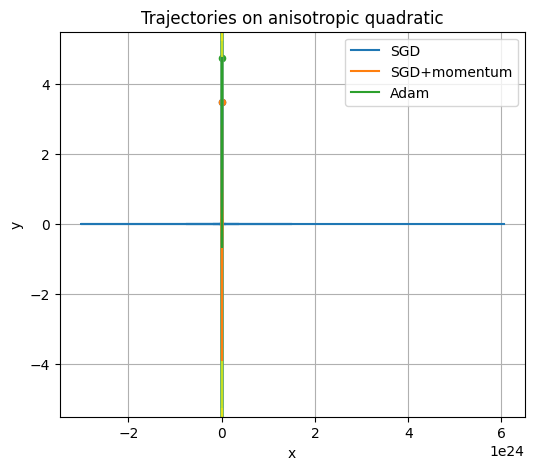

In [24]:
# 2D demo: как разные оптимизаторы идут к минимуму

import numpy as np
import torch
import matplotlib.pyplot as plt


def run_optimizer_2d(optimizer_factory, *, steps: int = 80, a: float = 10.0, b: float = 1.0):
    theta = torch.tensor([5.0, 5.0], requires_grad=True)
    optimizer = optimizer_factory([theta])

    trajectory = []
    for _ in range(steps):
        optimizer.zero_grad()
        loss = a * theta[0] ** 2 + b * theta[1] ** 2
        loss.backward()
        optimizer.step()
        trajectory.append(theta.detach().cpu().numpy().copy())

    return np.stack(trajectory, axis=0)


a, b = 10.0, 1.0
steps = 80

trajectories = {
    "SGD": run_optimizer_2d(lambda params: torch.optim.SGD(params, lr=0.15), steps=steps, a=a, b=b),
    "SGD+momentum": run_optimizer_2d(lambda params: torch.optim.SGD(params, lr=0.15, momentum=0.9), steps=steps, a=a, b=b),
    "Adam": run_optimizer_2d(lambda params: torch.optim.Adam(params, lr=0.25), steps=steps, a=a, b=b),
}

# Контуры функции
xs = np.linspace(-5.5, 5.5, 200)
ys = np.linspace(-5.5, 5.5, 200)
X, Y = np.meshgrid(xs, ys)
Z = a * X**2 + b * Y**2

plt.figure(figsize=(6, 5))
plt.contour(X, Y, Z, levels=25)

for name, traj in trajectories.items():
    plt.plot(traj[:, 0], traj[:, 1], label=name)
    plt.scatter(traj[0, 0], traj[0, 1], s=20)

plt.title("Trajectories on anisotropic quadratic")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
adam = optim.Adam(mlp_adam.parameters(), lr=3e-4)

adam.zero_grad()
pred = mlp_adam(x)
loss = torch.nn.functional.mse_loss(pred, y)
loss.backward()
adam.step()

In [ ]:
!nvidia-smi

### SGD

Потребляет меньше видеопамяти (ноль), тк не хранит моменты


In [ ]:
sgd = optim.SGD(mlp_sgd.parameters(), lr=3e-4)

sgd.zero_grad()
pred = mlp_sgd(x)
loss = torch.nn.functional.mse_loss(pred, y)
loss.backward()
sgd.step()

In [ ]:
!nvidia-smi

# Регуляризация

In [ ]:
import torch
import torch.nn as nn

## Dropout

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
dropout = nn.Dropout(p=0.5)
dropout.eval()
print(dropout.training) # важный флажок для дропаута - тк дропаут имеет разное поведение в процессе обучения и в процессе вычисления сети
dropout.train()
print(dropout.training)

dropout

In [ ]:
list(dropout.parameters())

In [ ]:
t = torch.rand([3, 5], dtype=torch.float32)

print("t.mean()", t.mean().item())

t

In [ ]:
# Sequential( Linear(2, 16), Dropout(0.3) ) #  пример использования

In [ ]:
# 1 / (1-p)

In [ ]:
dropout.eval()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

assert torch.allclose(t_dropouted, t), "eval dropout doesn't change input tensor"

t_dropouted

In [ ]:
dropout.train()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

print("zeros count", (t_dropouted == 0.0).sum().item(), "of", t_dropouted.numel())

t_dropouted

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout()

m = Model()
m.training

In [ ]:
m = m.eval()
m.dropout.training

In [ ]:
m = m.train()
m.dropout.training

## LabelSmoothing

In [ ]:
nn.CrossEntropyLoss(label_smoothing=0.1)

<img src="static/label_smoothing.png" width="400" />

## WeightDecay

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (..., weight_decay=0.1)

* [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

Stack Overflow: [AdamW and Adam with weight decay](https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay)

В чем разница:

* Adam + weight_decay --- регуляризация идет через градиенты
```
final_loss = loss + wd * all_weights.pow(2).sum() / 2
# backward ...
# optimizer.step:
w = w - lr * w.grad # grad contains regularisation
```

* AdamW --- регуляризация не идет через лосс
```
w = w - lr * w.grad - lr * wd * w
```


In [ ]:
import torch.optim as optim

dummy_module_params = nn.Linear(1, 1).parameters()
adam = optim.Adam(dummy_module_params, weight_decay=0.01)

dummy_module_params = nn.Linear(1, 1).parameters()
adamw = optim.AdamW(dummy_module_params, weight_decay=0.1)

# Обновим Trainer и нашу модель


* Добавим поддержку lr_sheduler
* В модельку добавим дропаут

In [ ]:
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

# ничего нового, копипаста с предыдущего сема
class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255


        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

In [ ]:
# Новый модуль
flatten_module = nn.Flatten(start_dim=1, end_dim=-1)
flatten_module(torch.rand([ 64, 28, 28 ])).shape

In [ ]:
# Что добавилось:
# * `nn.Dropout`, и параметр `dropout_p` - новый слой и параметр в `__init__`
# * `nn.Flatten` - новый слой для схлопывания размерностей на входящих тензорах

class MLPModel(nn.Module):
    """
    Реализация MLP. Похожее мы уже видели на 1 и 2 семинаре.
    """

    def __init__(self, dropout_p=0.5, activation=None):
        """
        Инициализация модели.

        :param activation: Функция активации (по умолчанию ReLU).
        :param dropout_p: Процент зануляемых значений в активациях
        """
        super().__init__()

        if activation is None:
            activation = nn.ReLU()

        self.inner = nn.Sequential(
            # input ~ [ bs, 28, 28 ]
            nn.Flatten(), # ~ [ bs, 28 * 28 ]
            nn.Linear(784, 100),
            nn.Dropout(p=dropout_p),
            activation,
            nn.Linear(100, 10),
        )

        # nn.Sequential последовательно применяет переданные слои
        # self.linear_1 = nn.Linear(784, 100)
        # self.activation = nn.ReLU()
        # self.linear_2 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямой проход данных через модель.

        :param x: Входные данные ~ [ bs, 784 ]
        :return: Выходные логиты модели ~ [ bs, 10 ]
        """
        return self.inner(x)

    def compute_all(self, batch):
        """
        Вычисляет лосс и точность по батчу данных.

        :param batch: Батч данных, содержащий 'sample' (входные данные) и 'label' (метки классов).
        :return: Значение функции потерь и словарь метрик.
        """

        x = batch['sample']    # [ bs, 784 ]
        y = batch['label']     # [ bs ] torch.LongTensor
        logits = self.inner(x) # [ bs, 10 ]

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = {
            "metrics/acc": acc,
            "metrics/loss": loss.detach().item(),
        }
        return loss, metrics


## Про Trainer (без внешних ссылок)

Мы уже писали похожий `Trainer` на прошлом семинаре. Здесь он чуть расширен:
- добавляем поддержку **lr scheduler**
- выбираем, когда его шагать: **per_batch** или **per_epoch**
- логируем метрики в **TensorBoard**

Важно: сам `Trainer` — это просто удобная обертка над циклом обучения, чтобы не копипастить одно и то же.

In [ ]:
# TensorBoard (Colab)
# Логи будут писаться в папку runs/03_seminar

%load_ext tensorboard

LOG_DIR = "runs/03_seminar"

# Запуск интерфейса можно делать после первого обучения:
# %tensorboard --logdir runs/03_seminar

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable

from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter


@dataclass(frozen=True)
class TrainerConfig:
    log_dir: str = "runs/03_seminar"
    batch_size: int = 128
    lr_scheduler_type: str | None = None  # None | 'per_batch' | 'per_epoch'


class Trainer:
    """Обертка над обучением модели.

    Держит вместе:
    - model
    - optimizer
    - train/val datasets + dataloaders
    - (опционально) lr scheduler
    - логирование в TensorBoard
    """

    def __init__(
        self,
        model: nn.Module,
        optimizer: Optimizer,
        train_dataset: Iterable,
        val_dataset: Iterable,
        *,
        config: TrainerConfig | None = None,
        lr_scheduler: LRScheduler | None = None,
    ):
        if config is None:
            config = TrainerConfig()

        if config.lr_scheduler_type not in [None, "per_batch", "per_epoch"]:
            raise ValueError(
                "lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                f"Not: {config.lr_scheduler_type}"
            )

        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = config.batch_size
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = config.lr_scheduler_type

        self.device: str | int = "cpu"
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = SummaryWriter(log_dir=config.log_dir)

    def close(self) -> None:
        self.writer.flush()
        self.writer.close()

    def log_scalars(self, log_data: dict[str, float], step: int | None = None) -> None:
        if step is None:
            step = self.global_step

        for key, value in log_data.items():
            self.writer.add_scalar(key, float(value), step)

    def save_checkpoint(self, path: str) -> None:
        """Сохраняет веса модели в указанный путь."""
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int) -> None:
        train_loader = DataLoader(
            self.train_dataset,
            shuffle=True,
            pin_memory=True,
            batch_size=self.batch_size,
        )

        # Валидационный датасет не стоит перемешивать
        val_loader = DataLoader(
            self.val_dataset,
            shuffle=False,
            pin_memory=True,
            batch_size=self.batch_size,
        )

        best_loss = float("inf")

        for epoch in range(num_epochs):
            self.model.train()
            for batch in train_loader:
                self.training_step(batch)
                self.post_train_batch()
                self.global_step += 1

            self.model.eval()

            val_losses: list[float] = []
            for batch in val_loader:
                loss = self.validation_step(batch)
                val_losses.append(float(loss.item()))

            val_loss = float(np.mean(val_losses))
            self.log_scalars({"validation/loss": val_loss}, step=epoch)

            # Сохраняем только наилучшую модель
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

            self.post_val_stage(val_loss)

        self.close()

    def training_step(self, batch) -> None:
        self.optimizer.zero_grad()

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        loss.backward()
        self.optimizer.step()

        # Логирование метрик обучения
        log_metrics = {f"train/{k}": float(v) for k, v in details.items()}
        log_metrics["train/loss"] = float(loss.item())
        self.log_scalars(log_metrics)

    def validation_step(self, batch):
        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, _details = self.model.compute_all(batch)
        return loss

    def post_train_batch(self) -> None:
        # called after every train batch
        if self.lr_scheduler is None or self.lr_scheduler_type != "per_batch":
            return

        self.lr_scheduler.step()

        # Берем lr для первой группы параметров
        lr = float(self.optimizer.param_groups[0]["lr"])
        self.log_scalars({"train/learning_rate": lr})

    def post_val_stage(self, val_loss: float) -> None:
        if self.lr_scheduler is None or self.lr_scheduler_type != "per_epoch":
            return

        if isinstance(self.lr_scheduler, ReduceLROnPlateau):
            self.lr_scheduler.step(val_loss)
        else:
            self.lr_scheduler.step()

        lr = float(self.optimizer.param_groups[0]["lr"])
        self.log_scalars({"validation/learning_rate": lr}, step=self.global_step)


### Не забудь поменять Runtime Type в колабе на GPU!

In [ ]:
import torch.utils.data

# берем часть исходной обучающей выборки для большей наглядности эффекта применения дропаута
# на большом датасете сложнее переобучиться, поэтому мы искусственно уменьшаем его для наглядности на занятии
# на практике не надо так делать!
fmnist_train_subset = torch.utils.data.Subset(fmnist_train, range(0, len(fmnist_train), 400))

### `dropout=0`

In [ ]:
model = MLPModel(dropout_p=0.0)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(
    model,
    optimizer,
    fmnist_train_subset,
    fmnist_val,
    config=TrainerConfig(log_dir=f"{LOG_DIR}/dropout_p_0.0"),
)
trainer.train(30)

### `dropout=0.3`

In [ ]:
model = MLPModel(dropout_p=0.3)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(
    model,
    optimizer,
    fmnist_train_subset,
    fmnist_val,
    config=TrainerConfig(log_dir=f"{LOG_DIR}/dropout_p_0.3"),
)
trainer.train(30)

### TensorBoard (как смотреть логи в Colab)

1. Убедитесь, что вы запускали обучение хотя бы один раз (в `runs/03_seminar` появятся event-файлы).
2. Запустите TensorBoard в отдельной ячейке:

```python
%tensorboard --logdir runs/03_seminar
```

Если вы запускаете несколько экспериментов, удобно логировать в подпапки:
- `runs/03_seminar/dropout_p_0.0`
- `runs/03_seminar/dropout_p_0.3`
- `runs/03_seminar/CyclicLR`

TensorBoard сам подхватит все подпапки.

(Скриншоты W&B убрали: логи теперь в TensorBoard.)

# LR Scheduler

Два типа расписаний:

- по эпохам ([StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), ...)
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам ([Cyclic](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html), [1cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

In [ ]:
def show_scheduler(scheduler, label=None):
    lr_history = []

    if label is None:
        label = str(scheduler)

    for i in range(100):
        lr_history.append(scheduler.get_last_lr()[0])
        scheduler.step()

    plt.plot(lr_history, label=label)


In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5), label="StepLR gamma=0.5" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25), label="StepLR gamma=0.25" )

plt.legend()

plt.title("StepLR")

#### Пример обучения с использованием step lr

![](static/step_lr_visualization.jpg)

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.1" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.05" )

plt.legend()

plt.title("CyclicLR")

**Вопрос:** в каких случаях может быть полезен `CyclicLR`? Зачем повышать `lr`?

<!-- если во время оптимизации попали в локальный минимум, с увеличением lr можем выскочить из этого локального минимума и попасть в более глубокую 'лунку' -->

#### Обучим модельку с шедулером


In [ ]:
model = MLPModel()

base_lr = 1e-3
max_lr = 0.005

optimizer = Adam(model.parameters(), lr=base_lr)
cyclic_lr = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    step_size_up=10,
    cycle_momentum=False,
)

trainer = Trainer(
    model,
    optimizer,
    fmnist_train_subset,
    fmnist_val,
    config=TrainerConfig(
        log_dir=f"{LOG_DIR}/CyclicLR",
        lr_scheduler_type="per_batch",
    ),
    lr_scheduler=cyclic_lr,
)
trainer.train(30)

(Графики для CyclicLR смотрим в TensorBoard: `runs/03_seminar/CyclicLR`.)

# WarmUp

**Проблема:** очень большие сетки может сильно разнести, если сразу начать их оптимизировать на больших батчах.

Чтобы сеть не расходилась сразу, можно постепенно увеличивать lr — тогда оптимизаторы постепенно накопят статистики по разным группам параметров.

Практическое правило про порядок вызовов:
- если scheduler шагается **на каждом батче**, то чаще всего порядок такой: `optimizer.step(); scheduler.step()`
- если scheduler шагается **на каждой эпохе**, то его обычно вызывают в конце эпохи (иногда после валидации)

In [ ]:
import math
import matplotlib.pyplot as plt
import torch


def plot_lr_schedule(optimizer, scheduler, num_steps: int, title: str) -> None:
    lr_history = []
    for _ in range(num_steps):
        lr_history.append(float(optimizer.param_groups[0]["lr"]))
        scheduler.step()

    plt.plot(lr_history)
    plt.title(title)
    plt.xlabel("step")
    plt.ylabel("lr")
    plt.grid(True)


# Визуализация warmup + cosine (через LambdaLR)
base_lr = 3e-4
num_steps = 200
warmup_steps = 20

param = torch.nn.Parameter(torch.zeros(()))
optimizer = torch.optim.Adam([param], lr=base_lr)

# lr_factor(step): [0..1] на warmup, затем cosine до 0

def lr_factor(step: int) -> float:
    if step < warmup_steps:
        return float(step + 1) / float(warmup_steps)

    progress = float(step - warmup_steps) / float(max(1, num_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_factor)

plt.figure(figsize=(8, 3))
plot_lr_schedule(optimizer, scheduler, num_steps=num_steps, title="Warmup + Cosine (LambdaLR)")
plt.show()

# Для сравнения: чистый cosine без warmup
param = torch.nn.Parameter(torch.zeros(()))
optimizer = torch.optim.Adam([param], lr=base_lr)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)

plt.figure(figsize=(8, 3))
plot_lr_schedule(optimizer, cosine, num_steps=num_steps, title="CosineAnnealingLR (no warmup)")
plt.show()

# Блиц по практике обучения нейросетей


### Может ли быть лосс отрицательным?

### Зачем нужен lr warmup?

<!---

Используется для обучения больших сетей для того, чтобы

-->

### Зачем нужен lr scheduling?

<!---

Чтобы получить лучшее качество модели или увеличить скорость обучения. Например, в начале обучения мы хотим побыстрее прийти к области с точкой оптимума. Но после того как мы к ней приблизились мы можем захотеть уменьшить lr для того, чтобы более точно подобрать значения параметров

--->



### Как нужно изменить lr, если мы увеличили batch_size в 3 раза?

<!---

Для того, чтобы сохранить такую же скорость оптимизации LR нужно тоже увеличить в 3 раза.*

* Для определенной задачи, батч сайза


PS Хотя вообще говоря, это очень спорно. Можно придумать много граничных кейсов. Например, для простых задач может быть даже более эффективно обучаться на маленьком батчсайзе. Потому что чем меньше батч, тем быстрее вычисления и тем больше шагов оптимизации мы сможем сделать за единицу времени.

-->


### Как выбрать хорошие начальные значения для lr?

<!---

С помощью LR Finder'а

Строим зависимость Loss(learning_rate) и ищем точку перегиба. Диапозон неплохих lr будет начинаться в точке перегиба (возможно чуть левее), когда сеть начинает учиться, а заканчиваться до момента, когда лосс начинает шуметь, флуктуировать, колбасить

--->


### Как будет обучаться модель, если в нее добавить слой `nn.Dropout(p=1.0)`

<!-- Никак, потому что такой слой просто занулит тензор полностью -->

### Зачем внутри `Dropout` делается умножение на `1/(1-p)`? Что будет, если этого не сделать?

### Как изменяется поведение модуля `nn.Dropout` после того, как мы переключили модель в режим вычисления (`model.eval()`)?

<!-- Из доки торча: "During evaluation the module simply computes an identity function." -- лучше и не скажешь) https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html -->

### Для чего вообще нужен `nn.Dropout`?

<!-- Способ регуляризации, с дропаутом модели сложнее переобучиться на тренировочный датасет, улучшается обобщающая способность сети -->


### Мы хотим обучить модель на `1M` параметров с помощью `SGD` и с помощью `Adam`. Как изменится необходимый объем видеопамяти для обучения модели в зависимости от оптимизатора?

### Зачем `Adam` использует скользящее среднее для вычисления моментов?

### Зачем мы используем GPU для обучения/вычисления нейросетей?

### Нашел отзыв на яндекс маркете. Про какой это оптимизатор?

<!-- На самом деле, нельзя однозначно сказать. Это может быть как Adam, так и SGD с моментом или любой другой оптимизатор, которых хранит статистики по градиентам. -->

![](static/ya_market_optimizer_review.png)

# Домашки:

* dropout
* optimization